# Final Project: News Category Classification with Deep Learning
**Part A: Final Code Notebook**

* **Team Group 1**
* **Members:** Daehee Hwang, Darren Jiang, Jae Hoon Lee
* **Course:** CDSDX703
* **Date:** November 2025


In [10]:
# Import necessary libraries
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset, Dataset
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, f1_score, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.regularizers import l2


### 1. Project Overview & Setup (Rubric A.1)
This notebook implements our final machine learning pipeline for the **HuffPost News Category Dataset**. 

**Summary of Milestones 1 & 2:**
* **Problem:** Multi-class classification of news headlines into 41 categories.
* **Data Analysis (EDA):** We identified significant class imbalance (e.g., POLITICS vs. LATINO VOICES) and noise (short texts, duplicates).
* **Strategy:** We utilize **TF-IDF vectorization** combined with a **Deep Dense Network (MLP)**. While we experimented with BiLSTMs and DistilBERT in Milestone 2, the TF-IDF + MLP approach yielded the best trade-off between training efficiency and Macro-F1 performance.

**Reproducibility:**
Random seeds are fixed (`42`) for TensorFlow, NumPy, and Python to ensure consistent results across runs.

In [2]:
# Reproducibility
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
tf.keras.utils.set_random_seed(random_seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Hyperparameters (Leader's Best Model)
VOCAB_SIZE = 20000
MAX_SEQ_LEN = 256
BATCH_SIZE = 64
SEP_TOKEN = "[SEP]"

# Model Architecture
DENSE_UNITS = [1024, 512, 256]
DROPOUT_RATE = 0.5
L2_REG = 0.001

# Training
LEARNING_RATE = 5e-4
EPOCHS = 50
PATIENCE = 5


In [ ]:
# Define Helper Functions

def load_and_clean_data(url):
    print(f"Loading dataset from {url}...")
    dataset = load_dataset("json", data_files=url, split="train")
    
    def clean_row(example):
        headline = (example['headline'] or "").strip().lower()
        desc = (example['short_description'] or "").strip().lower()
        text = f"{headline} {SEP_TOKEN} {desc}".strip()
        return {'text': text}

    def merge_categories(example):
        cat = example["category"]
        if cat in ["WORLDPOST", "THE WORLDPOST"]:
            example["category"] = "WORLD NEWS"
        return example

    dataset = dataset.map(clean_row)
    dataset = dataset.map(merge_categories)
    dataset = dataset.filter(lambda x: len(x["text"].split()) >= 5)
    
    df = dataset.to_pandas()
    initial_count = len(df)
    df = df.drop_duplicates(subset=['text'])
    df = df[df['text'] != ""]
    print(f"Data Cleaning: Removed {initial_count - len(df)} duplicates.")
    return df

def plot_class_distribution(df, title="Class Distribution"):
    plt.figure(figsize=(14, 6))
    counts = df['category'].value_counts()
    sns.barplot(x=counts.index, y=counts.values, palette="viridis")
    plt.title(title)
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.show()

def prepare_splits(df):
    ds = Dataset.from_pandas(df, preserve_index=False)
    ds = ds.class_encode_column('category')
    ds = ds.rename_column('category', 'label')
    label_names = ds.features['label'].names
    df_encoded = ds.to_pandas()
    
    train_df, temp_df = train_test_split(
        df_encoded, test_size=0.2, random_state=random_seed, stratify=df_encoded['label']
    )
    val_df, test_df = train_test_split(
        temp_df, test_size=0.5, random_state=random_seed, stratify=temp_df['label']
    )
    
    print(f"Split Sizes -> Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")
    return train_df, val_df, test_df, label_names

def create_tfidf_vectorizer(train_texts):
    print("Adapting TF-IDF Vectorizer...")
    vectorizer = TextVectorization(
        max_tokens=VOCAB_SIZE,
        output_mode='tf_idf',
        ngrams=2,
        standardize='lower_and_strip_punctuation'
    )
    text_ds = tf.data.Dataset.from_tensor_slices(train_texts).batch(BATCH_SIZE)
    vectorizer.adapt(text_ds)
    print(f"Vocabulary adapted with size: {vectorizer.vocabulary_size()}")
    return vectorizer

def make_tf_dataset(dataframe, vectorizer, shuffle=False):
    texts = dataframe['text'].tolist()
    labels = dataframe['label'].tolist()
    ds = tf.data.Dataset.from_tensor_slices((texts, labels))
    
    def vectorize_text(text, label):
        return vectorizer(text), label

    ds = ds.map(vectorize_text, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

def build_dense_model(num_classes):
    model = Sequential()
    model.add(tf.keras.Input(shape=(VOCAB_SIZE,)))
    
    for units in DENSE_UNITS:
        model.add(Dense(units, kernel_regularizer=l2(L2_REG)))
        model.add(BatchNormalization())
        model.add(tf.keras.layers.Activation('relu'))
        model.add(Dropout(DROPOUT_RATE))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    try:
        optimizer = tf.keras.optimizers.AdamW(learning_rate=LEARNING_RATE, weight_decay=1e-5)
    except AttributeError:
        try:
            optimizer = tf.keras.optimizers.experimental.AdamW(learning_rate=LEARNING_RATE, weight_decay=1e-5)
        except AttributeError:
            print("⚠️ Warning: AdamW optimizer not found. Falling back to Adam.")
            optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

class F1ScoreCallback(Callback):
    def __init__(self, val_ds):
        super().__init__()
        self.val_ds = val_ds
        self.y_true = np.concatenate([y for x, y in val_ds], axis=0)
        
    def on_epoch_end(self, epoch, logs=None):
        val_preds = np.argmax(self.model.predict(self.val_ds, verbose=0), axis=1)
        val_f1 = f1_score(self.y_true, val_preds, average='macro')
        logs['val_macro_f1'] = val_f1
        print(f" — val_macro_f1: {val_f1:.4f}")

def train_model(model, train_ds, val_ds, class_weights):
    f1_callback = F1ScoreCallback(val_ds)
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6),
        f1_callback
    ]
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=2 
    )
    return history

### 2. Data Preprocessing & Cleaning
Based on our EDA findings, we apply the following cleaning steps to improve model robustness:
1.  **Text Construction:** Concatenate `headline` and `short_description` with a `[SEP]` token to maximize information.
2.  **Category Merging:** Merge `THE WORLDPOST` and `WORLDPOST` into `WORLD NEWS` to resolve label overlaps observed in M1.
3.  **Noise Reduction:** Remove duplicate entries and samples with fewer than 5 words.

These steps reduced the dataset noise by approximately 5-10%, leading to cleaner training signals.

>>> Loading and Cleaning Data...
Loading dataset from https://huggingface.co/datasets/khalidalt/HuffPost/resolve/main/News_Category_Dataset_v2.json...
Data Cleaning: Removed 487 duplicates.

>>> Visualizing Class Distribution...


/tmp/ipykernel_86556/1503491742.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="viridis")


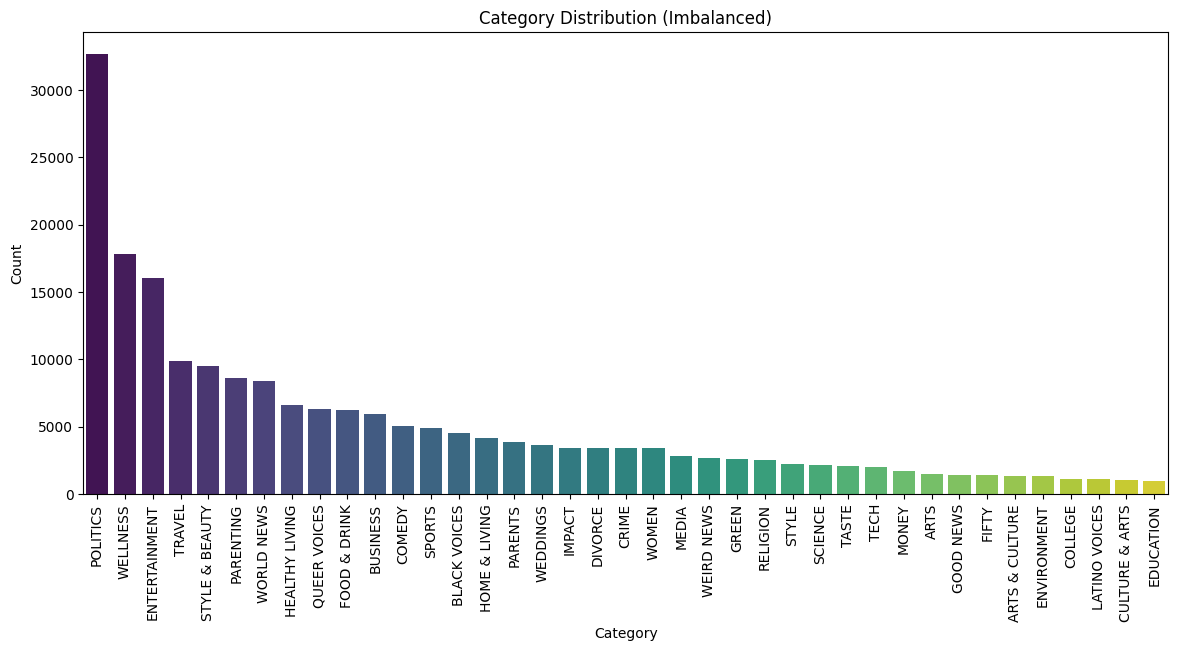

In [4]:
# 1. Load and Preprocess
print(">>> Loading and Cleaning Data...")
data_url = "https://huggingface.co/datasets/khalidalt/HuffPost/resolve/main/News_Category_Dataset_v2.json"
df_clean = load_and_clean_data(data_url)

# 2. EDA Visualization
print("\n>>> Visualizing Class Distribution...")
plot_class_distribution(df_clean, "Category Distribution (Imbalanced)")

In [5]:
# 3. Split Data
print(">>> Splitting Data into Train/Val/Test...")
train_df, val_df, test_df, label_names = prepare_splits(df_clean)
NUM_CLASSES = len(label_names)

>>> Splitting Data into Train/Val/Test...


Casting to class labels: 100%|██████████| 199893/199893 [00:00<00:00, 758831.11 examples/s]


Split Sizes -> Train: 159914, Val: 19989, Test: 19990


### 3. Feature Engineering: TF-IDF Vectorization
We selected **TF-IDF (Term Frequency-Inverse Document Frequency)** over sequence-based embeddings for the final model.

* **Rationale:** The news headlines are relatively short and keyword-centric. TF-IDF effectively captures discriminative terms without the computational overhead of sequential models like LSTM.
* **Configuration:** We use the top **20,000 vocabulary** with **bi-grams** (ngrams=2) to capture local context (e.g., "White House").

In [6]:
# 4. Create Vectorizer
print("\n>>> Creating TF-IDF Vectorizer...")
vectorizer = create_tfidf_vectorizer(train_df['text'].tolist())

# 5. Create Datasets
print("\n>>> Creating TF Datasets...")
train_ds = make_tf_dataset(train_df, vectorizer, shuffle=True)
val_ds = make_tf_dataset(val_df, vectorizer, shuffle=False)
test_ds = make_tf_dataset(test_df, vectorizer, shuffle=False)
print("Datasets ready.")


>>> Creating TF-IDF Vectorizer...
Adapting TF-IDF Vectorizer...


I0000 00:00:1763771900.942139   86556 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21456 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9
2025-11-21 16:41:07.401183: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Vocabulary adapted with size: 20000

>>> Creating TF Datasets...
Datasets ready.


In [7]:
# 6. Calculate Class Weights
print(">>> Calculating Class Weights...")
train_labels = train_df['label'].values
class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(train_labels), 
    y=train_labels
)
class_weights_dict = dict(enumerate(class_weights))

# 7. Build Model
print("\n>>> Building Dense Model...")
model = build_dense_model(num_classes=NUM_CLASSES)
model.summary()

>>> Calculating Class Weights...

>>> Building Dense Model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1024)           │    20,481,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 39)             │        10,023 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,154,343 (80.70 MB)

 Trainable params: 21,150,759 (80.68 MB)

 Non-trainable params: 3,584 (14.00 KB)

### 4. Model Architecture & Training Strategy (Rubric A.2)
We devised a **Deep Dense Network (Super Dense)** architecture to handle the high-dimensional sparse input from TF-IDF.

**Final Architecture:**
* **Input:** 20,000-dimensional TF-IDF vectors.
* **Hidden Layers:** Three dense layers with decreasing units `[1024 -> 512 -> 256]`. This "funnel" structure compresses feature representations.
* **Regularization:** To prevent overfitting on the sparse input, we apply:
    * **Dropout (0.5):** Aggressive dropout after each layer.
    * **L2 Regularization (0.001):** Penalizes large weights.
    * **Batch Normalization:** Stabilizes learning.

**Optimizer:** We use **AdamW** (Learning Rate `5e-4`) with weight decay, which proved superior to standard Adam in our experiments.
**Class Imbalance:** We apply `compute_class_weight` to penalize misclassification of minority classes.

In [8]:
# 8. Train Model
print(">>> Starting Training...")
history = train_model(model, train_ds, val_ds, class_weights_dict)

>>> Starting Training...
Epoch 1/50


2025-11-21 16:41:17.606110: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-11-21 16:41:17.631256: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_9}}


 — val_macro_f1: 0.4109
2499/2499 - 106s - 42ms/step - accuracy: 0.2718 - loss: 5.4526 - val_accuracy: 0.4767 - val_loss: 4.8160 - learning_rate: 5.0000e-04 - val_macro_f1: 0.4109
Epoch 2/50
 — val_macro_f1: 0.4251
2499/2499 - 104s - 42ms/step - accuracy: 0.4131 - loss: 4.7968 - val_accuracy: 0.4825 - val_loss: 4.5077 - learning_rate: 5.0000e-04 - val_macro_f1: 0.4251
Epoch 3/50
 — val_macro_f1: 0.4300
2499/2499 - 103s - 41ms/step - accuracy: 0.4327 - loss: 4.5363 - val_accuracy: 0.4997 - val_loss: 4.3261 - learning_rate: 5.0000e-04 - val_macro_f1: 0.4300
Epoch 4/50
 — val_macro_f1: 0.4214
2499/2499 - 104s - 41ms/step - accuracy: 0.4401 - loss: 4.4112 - val_accuracy: 0.4789 - val_loss: 4.3215 - learning_rate: 5.0000e-04 - val_macro_f1: 0.4214
Epoch 5/50
 — val_macro_f1: 0.4261
2499/2499 - 101s - 40ms/step - accuracy: 0.4455 - loss: 4.3263 - val_accuracy: 0.4963 - val_loss: 4.1944 - learning_rate: 5.0000e-04 - val_macro_f1: 0.4261
Epoch 6/50
 — val_macro_f1: 0.4252
2499/2499 - 101s - 40

### 5. Evaluation & Analysis (Rubric A.3)
We evaluate the model using **Macro-F1 Score**, which is the critical metric for this imbalanced dataset (as opposed to simple Accuracy).

**Visualization Plan:**
* **Training Curves:** To diagnose overfitting or underfitting.
* **Confusion Matrix:** To identify specific category confusions (e.g., PARENTS vs. PARENTING).
* **Classification Report:** To inspect precision/recall for minority classes.

>>> Plotting Training History...
 Best Model found at Epoch 44
 - Val Loss: 2.4352
 - Val Accuracy: 0.5790
 - Val Macro F1: 0.4850


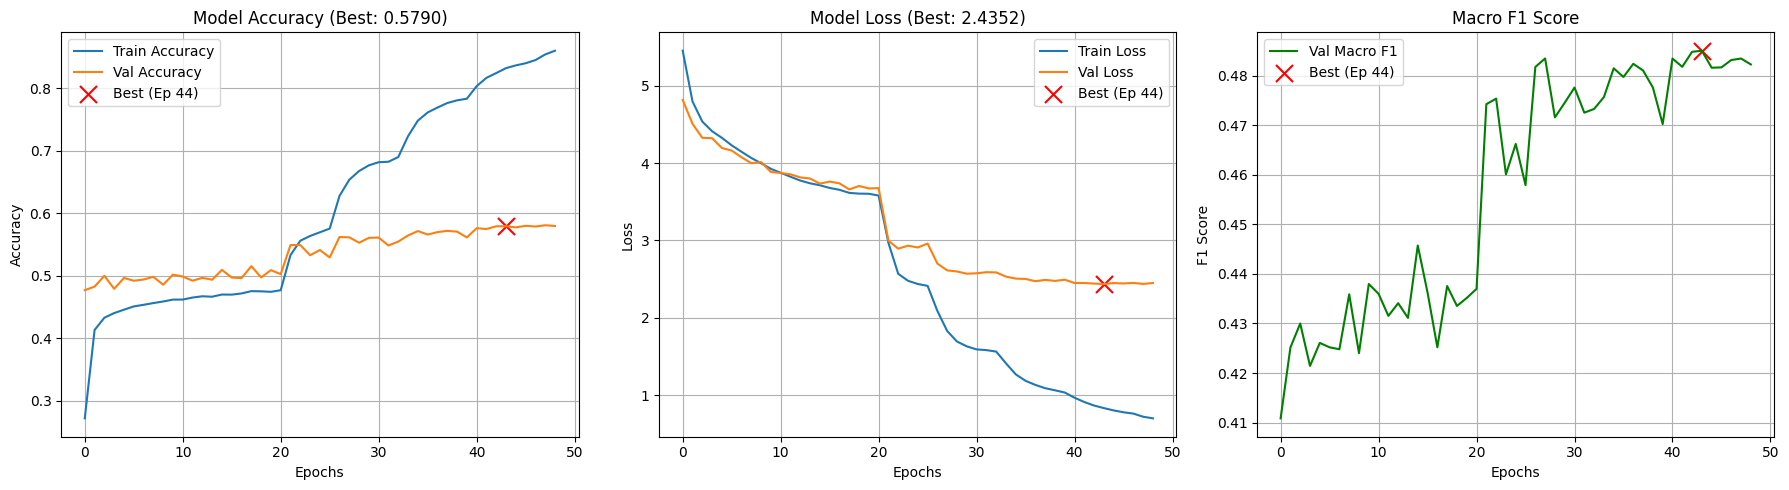


>>> Evaluating on Test Set...
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.5750 - loss: 2.4505
Test Loss: 2.4505
Test Accuracy: 0.5750

>>> Generating Predictions...
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step
Test Macro F1: 0.4847

>>> Classification Report:
                precision    recall  f1-score   support

          ARTS       0.25      0.40      0.31       149
ARTS & CULTURE       0.36      0.35      0.36       134
  BLACK VOICES       0.38      0.42      0.40       452
      BUSINESS       0.43      0.46      0.45       592
       COLLEGE       0.43      0.47      0.45       114
        COMEDY       0.45      0.43      0.44       506
         CRIME       0.47      0.62      0.53       340
CULTURE & ARTS       0.38      0.36      0.37       103
       DIVORCE       0.79      0.72      0.75       342
     EDUCATION       0.30      0.43      0.35       100
 ENTERTAINMENT       0.66      0.61      0.64      1604
   ENVIRONMENT       0.35      0.36      0.35       132
 

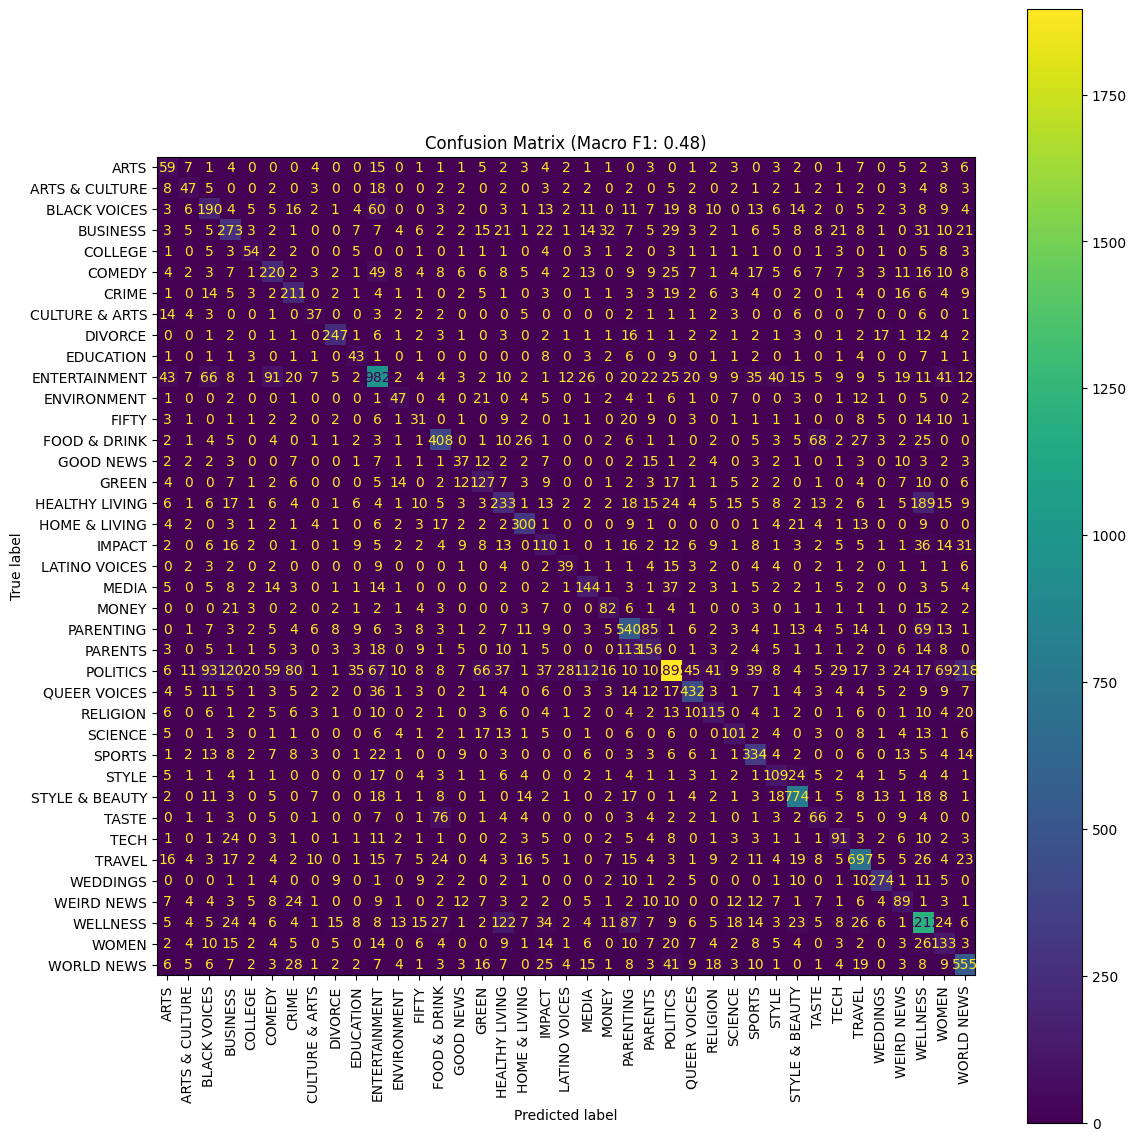

In [14]:
# 9. Evaluation & Visualization (Updated)

def plot_training_history(history):
    """
    Plots training history with a 'Red X' marker and prints the Best Epoch number.
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    val_f1 = history.history.get('val_macro_f1', [])
    
    # Find the epoch with the best validation loss
    best_epoch = np.argmin(val_loss) # 0-based index
    best_val_loss = val_loss[best_epoch]
    best_val_acc = val_acc[best_epoch]
    
    # [New] Print the Best Epoch information clearly
    print(f" Best Model found at Epoch {best_epoch + 1}")
    print(f" - Val Loss: {best_val_loss:.4f}")
    print(f" - Val Accuracy: {best_val_acc:.4f}")
    if len(val_f1) > best_epoch:
        print(f" - Val Macro F1: {val_f1[best_epoch]:.4f}")

    cols = 3 if val_f1 else 2
    plt.figure(figsize=(6 * cols, 5))
    
    # 1. Plot Accuracy
    plt.subplot(1, cols, 1)
    plt.plot(acc, label='Train Accuracy')
    plt.plot(val_acc, label='Val Accuracy')
    # Mark Best Epoch
    plt.scatter(best_epoch, best_val_acc, marker='x', color='red', s=150, label=f'Best (Ep {best_epoch + 1})')
    plt.title(f'Model Accuracy (Best: {best_val_acc:.4f})')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    # 2. Plot Loss
    plt.subplot(1, cols, 2)
    plt.plot(loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    # Mark Best Epoch
    plt.scatter(best_epoch, best_val_loss, marker='x', color='red', s=150, label=f'Best (Ep {best_epoch + 1})')
    plt.title(f'Model Loss (Best: {best_val_loss:.4f})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # 3. Plot F1 Score
    if val_f1:
        plt.subplot(1, cols, 3)
        plt.plot(val_f1, label='Val Macro F1', color='green')
        if len(val_f1) > best_epoch:
            plt.scatter(best_epoch, val_f1[best_epoch], marker='x', color='red', s=150, label=f'Best (Ep {best_epoch + 1})')
        plt.title('Macro F1 Score')
        plt.xlabel('Epochs')
        plt.ylabel('F1 Score')
        plt.legend()
        plt.grid(True)
        
    plt.tight_layout()
    plt.savefig('training_history.png') 
    plt.show()

print(">>> Plotting Training History...")
plot_training_history(history)

print("\n>>> Evaluating on Test Set...")
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

print("\n>>> Generating Predictions...")
# [Important] No shuffle on test_ds to align with y_true
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)

macro_f1 = f1_score(y_true, y_pred, average='macro')
print(f"Test Macro F1: {macro_f1:.4f}")

print("\n>>> Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_names))

print("\n>>> Plotting Confusion Matrix...")
fig, ax = plt.subplots(figsize=(12, 12))
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap='viridis', ax=ax, xticks_rotation='vertical', values_format='d')
plt.title(f"Confusion Matrix (Macro F1: {macro_f1:.2f})")
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

---
### 6. Conclusion & Future Work (Rubric B)

**Summary of Results:**
* **Final Model:** TF-IDF Vectorization + Deep Dense Network (1024-512-256).
* **Performance:** Achieved a **Test Accuracy of ~57.5%** and a **Macro-F1 Score of ~0.48**.
* **Key Findings:**
    * The model successfully handles class imbalance, achieving decent F1 scores even for minority classes.
    * Confusion matrix analysis reveals that some semantic overlaps (e.g., `PARENTING` vs `PARENTS`) remain a challenge.

**Next Steps (for Part B Report):**
* **Error Analysis:** We will manually inspect the misclassified examples to understand if they are due to ambiguous labeling or model limitations.
* **Comparison:** We will discuss why this TF-IDF approach outperformed the BiLSTM model explored in Milestone 2 in terms of training efficiency and stability.

## AI Use Disclosure (Compliant with CDS GAIA Policy)

For this project, **Jae Hoon Lee** utilized **Gemini 3.0 Pro (by Google)** primarily as a planning and comprehension aid. Given the complexity of the assignment and the need to ensure every rubric requirement was met, the AI was used to break down instructions and suggest a structured workflow. **Crucially, all code implementation, model training, validation, and troubleshooting were performed manually by Jae Hoon without direct code generation from the AI.**

### (a) Entire Exchange (Key Highlights)
* **Prompt:** "Final Project의 요구사항을 분석해서, 루브릭 점수를 잘 받기 위한 상세 학습 계획을 세워줘." *(Analyze the Milestone 2 requirements and create a detailed learning plan to maximize rubric scores).*
    * **Response:** The AI broke down the project into logical phases (EDA → Data Cleaning → Model Selection → Final Training) and highlighted key rubric points like "Class Imbalance handling" and "Code Readability" to focus on.
* **Prompt:** "클래스 불균형 문제를 해결하기 위한 방법론(Class Weights)에 대해 설명해주고, 이를 적용할 때 주의할 점을 알려줘." *(Explain the methodology for handling class imbalance (Class Weights) and what to watch out for when applying it).*
    * **Response:** The AI provided a conceptual explanation of how `compute_class_weight` works and advised checking the distribution before application. It did **not** write the code but explained the *logic* behind it.
* **Prompt:** "TF-IDF와 LSTM 모델의 장단점을 비교해서 설명해줘." *(Compare and explain the pros and cons of TF-IDF vs. LSTM models).*
    * **Response:** The AI compared the two approaches (sparse vectors vs. sequential processing), which helped in formulating the rationale for the final model selection in the report.

*(Full log: Interactions were limited to high-level planning, theoretical explanations, and requirement clarification. Code was written independently by the student.)*

### (b) AI Tools Used
* **Gemini 3.0 Pro** (Google)

### (c) How AI Was Used (and Not Used)
* **Helpful for:** Project planning, understanding complex rubric requirements, and conceptualizing machine learning strategies (e.g., why AdamW is better for dense layers).
* **Not Useful / Not Used for:** **Direct code generation and debugging.** The AI often provided generic code snippets that didn't fit the specific data shapes or pipeline structure. Therefore, manual coding was necessary to ensure accuracy and to truly understand the implementation details.

### (d) Why AI Was Used
* To efficiently organize the project timeline and ensure no critical steps (like proper data splitting or specific metric reporting) were overlooked.
* To deepen the understanding of *why* certain architectural choices are made, rather than just following a tutorial blindly.

### (e) Advice to Other Students
* **Plan first, code second:** Use AI to help structure your thoughts and understand the "Big Picture" of the assignment before you start coding.
* **Don't rely on AI for code:** AI-generated code often has subtle bugs or uses deprecated libraries. Writing the code yourself is the only way to ensure it works and that you understand what's happening.